# MACSS 30200 - Problem Set 2
By: Bethany Bailey
## Part 1
### (a)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

bq_data = np.loadtxt('BQmat_orig.txt', delimiter=',')

In [2]:
# Check if we need to rescale data. Since equal to one, we do not.
print(bq_data.sum())

1.0


In [3]:
print('Shape of BQ_mat_raw', bq_data.shape)
print('Bequest distribution by income group:',
      bq_data.sum(axis=0))

Shape of BQ_mat_raw (78, 7)
Bequest distribution by income group: [ 0.01214584  0.00817072  0.01590964  0.0139963   0.01383075  0.06927237
  0.86667437]


<IPython.core.display.Javascript object>


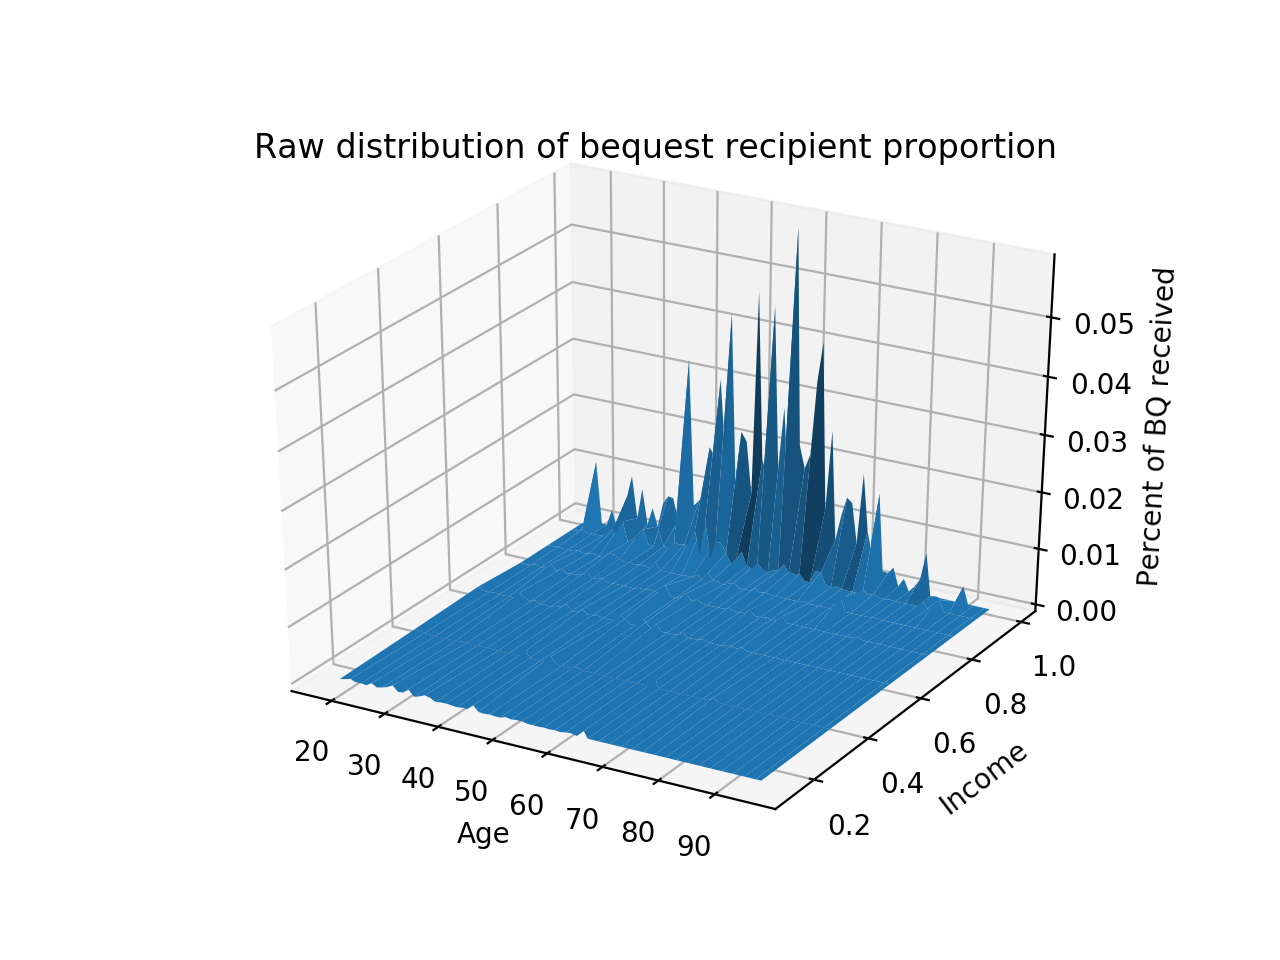

Text(0.5,0,'Percent of BQ received')

In [4]:
age_vec = np.arange(18, 96)
prcntl = np.array([0.25, 0.25, 0.20, 0.10, 0.10, 0.09, 0.01])
prcntl_mdpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85,
                          0.94, 0.995])
income_mat, age_mat = np.meshgrid(prcntl_mdpts, age_vec)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(age_mat, income_mat, bq_data)
ax.set_title('Raw distribution of bequest recipient proportion')
ax.set_xlabel('Age')
ax.set_ylabel('Income')
ax.set_zlabel('Percent of BQ received')

### (b)

In [5]:
from scipy.stats import gaussian_kde
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KernelDensity

/Users/bethanybailey/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/bethanybailey/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [75]:
# Find the best bandwidth.
pot_bandwidth = np.linspace(0.01, 2, 200)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': pot_bandwidth})
grid.fit(bq_data)
print('best bandwidth =', grid.best_params_)
print('accuracy =', grid.best_score_)

best bandwidth = {'bandwidth': 0.01}
accuracy = 644.9895495544532


From the above, the best bandwidth is 0.01. Upon using this bandwidth to plot my kde, I realized that it overfits the data too much (low bandwidths tend to overfit the data). Using this bandwidth doesn't get rid of the dips between the years that are a product of our data reporting in a year unit. However, I would like to see some variation in the data rather than just looking at a bell-curve, so I don't want the bandwidth to be too high. I played around with some bandwidths and decided to use a bandwidth of 0.25, which smooths out the surface to get rid of the year variation but doesn't lose the variation that higher bandwidths, like 0.5 or 1, do.

In [91]:
prop_mat_inc = np.sum(bq_data, axis=0)
prop_mat_age = np.sum(bq_data, axis=1)

bandwidth = 0.25

age_probs = np.random.multinomial(100000, prop_mat_age)
income_probs = np.random.multinomial(100000, prop_mat_inc)
age_freq = np.array([])
inc_freq = np.array([])

# Create age distribution.
for age, num in zip(age_vec, age_probs):
    vec_age = np.ones(num)
    vec_age *= age
    age_freq = np.append(age_freq, vec_age)

# Create income distribution
for income, num in zip(prcntl_mdpts, income_probs):
    vec_abil = np.ones(num)
    vec_abil *= income
    inc_freq = np.append(inc_freq, vec_abil)

data = np.vstack((age_freq, inc_freq))
density = gaussian_kde(data, bw_method=bandwidth)

ages_mat, incomes_mat = np.meshgrid(age_vec, prcntl_mdpts)

coords = np.vstack([item.ravel() for item in [ages_mat, incomes_mat]])
bq_kde = density(coords).reshape(ages_mat.shape)
bq_kde.sum()

15.333781043012367

In [92]:
# Scale the matrix to add to one.
bq_kde_scaled = bq_kde / bq_kde.sum()
bq_kde_scaled.sum()

1.0

<IPython.core.display.Javascript object>


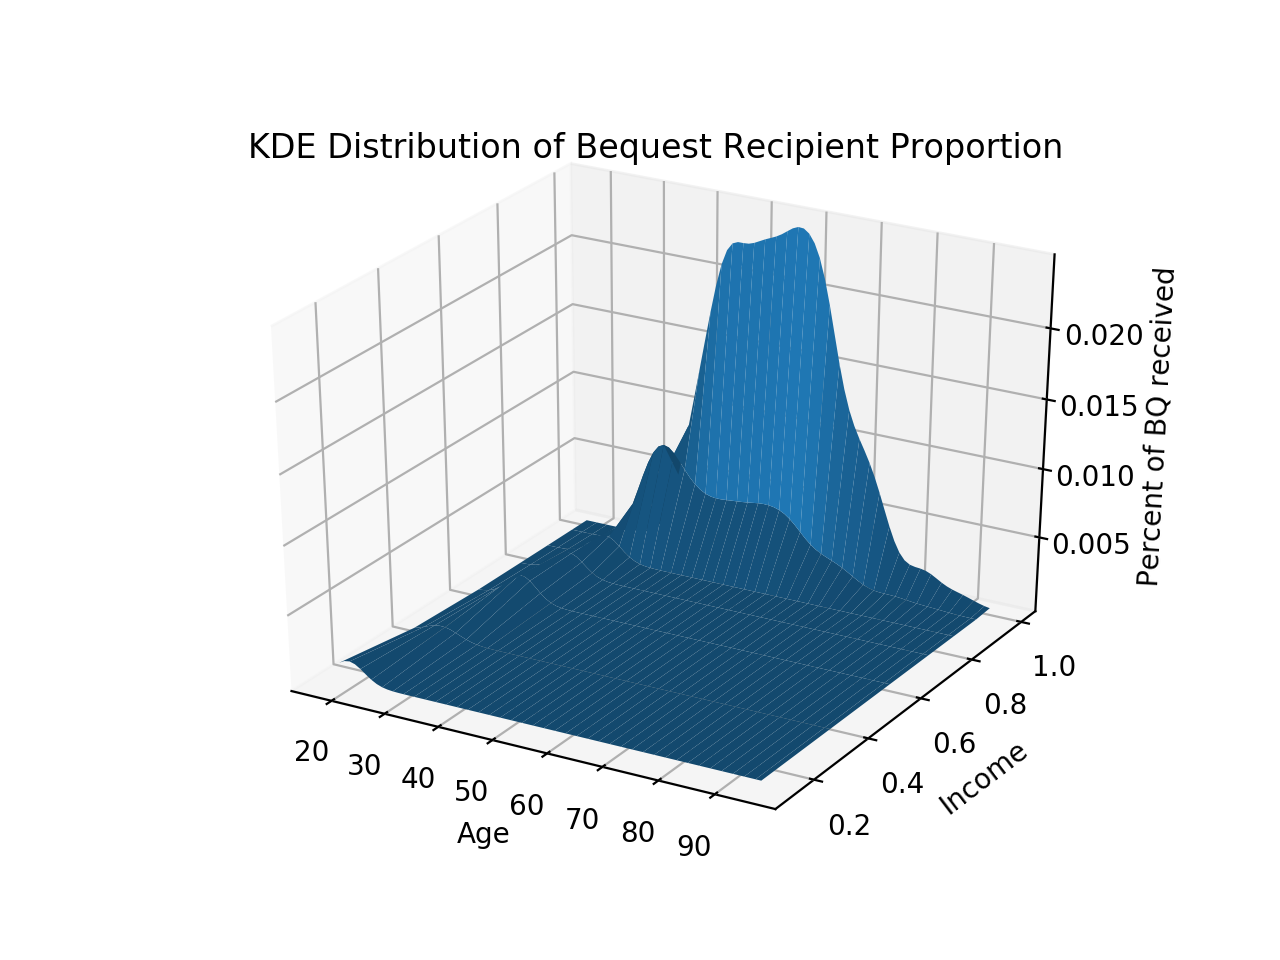

In [93]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(ages_mat, incomes_mat, bq_kde_scaled)
ax.set_title('KDE Distribution of Bequest Recipient Proportion')
ax.set_xlabel('Age')
ax.set_ylabel('Income')
ax.set_zlabel('Percent of BQ received')
plt.show()

In [181]:
print("The estimated density for bequest recipients who are age 61 in the 6th lifetime income category is", bq_kde_scaled[5,43])

The estimated density for bequest recipients who are age 61 in the 6th lifetime income category is 0.00404109052683


## Part 2
### (a)

In [94]:
import statsmodels.api as sm
import pandas as pd

/Users/bethanybailey/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [95]:
df = pd.read_csv("biden.csv")
df.head()

,biden,female,age,educ,dem,rep
0,90.0,0,19.0,12.0,1.0,0.0
1,70.0,1,51.0,14.0,1.0,0.0
2,60.0,0,27.0,14.0,0.0,0.0
3,50.0,1,43.0,14.0,1.0,0.0
4,60.0,1,38.0,14.0,0.0,1.0


In [96]:
df['age*education'] = df['age'] * df['educ']

In [97]:
df.head()

,biden,female,age,educ,dem,rep,age*education
0,90.0,0,19.0,12.0,1.0,0.0,228.0
1,70.0,1,51.0,14.0,1.0,0.0,714.0
2,60.0,0,27.0,14.0,0.0,0.0,378.0
3,50.0,1,43.0,14.0,1.0,0.0,602.0
4,60.0,1,38.0,14.0,0.0,1.0,532.0


In [98]:
df['const'] = 1
reg = sm.OLS(endog=df['biden'], exog=df[['const', 'age', 'educ', 'age*education']], missing='drop')

In [99]:
results = reg.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  biden   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     10.13
Date:                Mon, 30 Apr 2018   Prob (F-statistic):           1.29e-06
Time:                        07:50:26   Log-Likelihood:                -8333.3
No. Observations:                1826   AIC:                         1.667e+04
Df Residuals:                    1822   BIC:                         1.670e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            37.5491      9.491      3.956

The marginal effect of age on Joe Biden thermometer rating conditional on education $\beta_{1} + \beta_{3}X_2$, which in this case is $0.6674-0.0477X_2$, where $X_2$ is education. The coefficients are all significant at the $\alpha < 0.001$ level. The direction is negative (that is, the effect of age on thermometer/feelings toward Biden decreases as education increases).

We can see the relationship of this in the below plot:

<IPython.core.display.Javascript object>


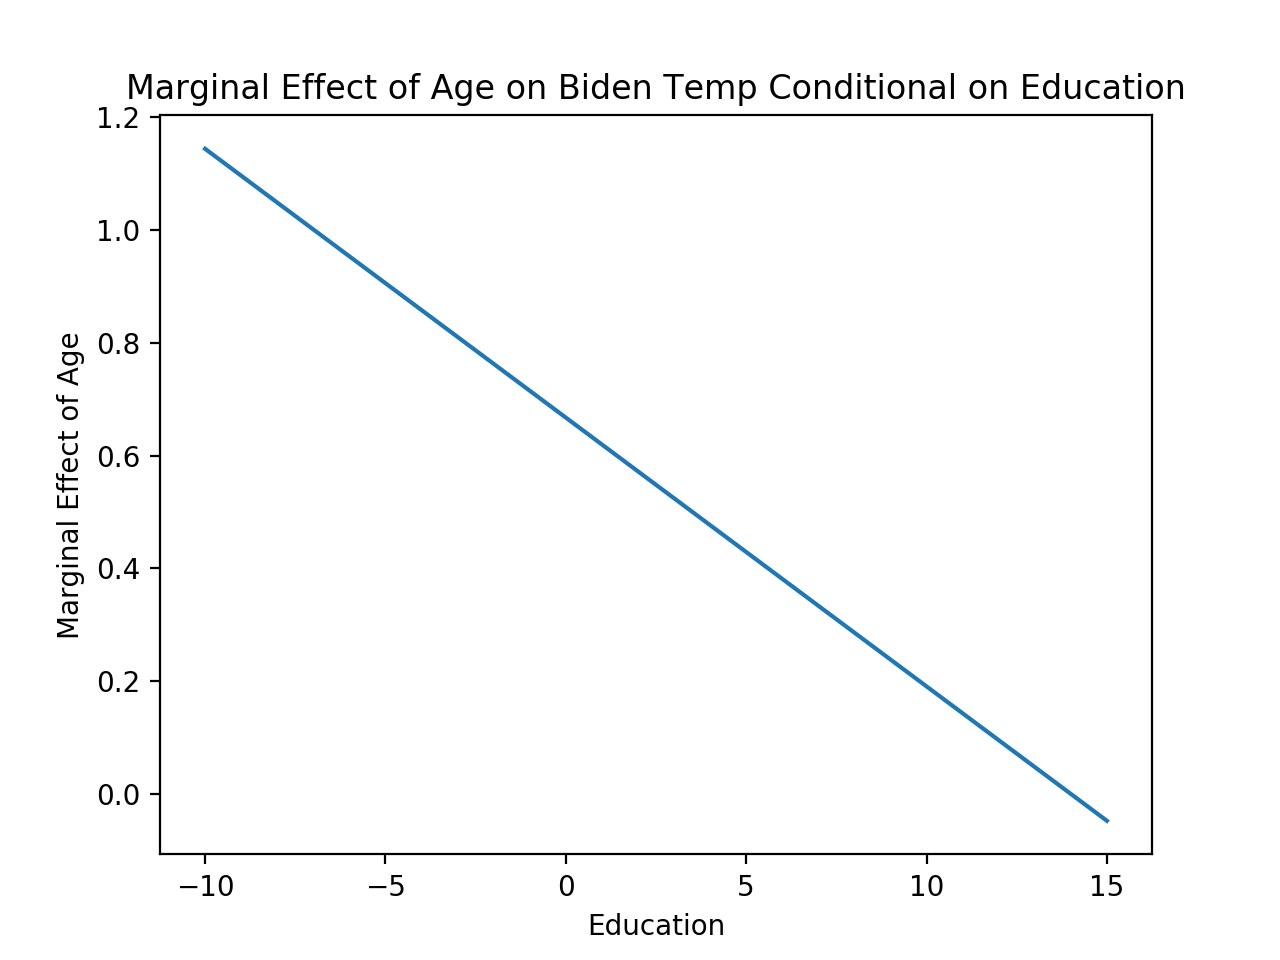

In [100]:
x = np.linspace(-10, 15, 100)    
fig, ax = plt.subplots()
ax.plot(x, (0.6674-0.0477*x))
ax.set_ylabel("Marginal Effect of Age")
ax.set_xlabel("Education")
ax.set_title("Marginal Effect of Age on Biden Temp Conditional on Education")
plt.show()

### (b)

The marginal effect of age on Joe Biden thermometer rating conditional on education $\beta_{2} + \beta_{3}X_1$, which in this case is $0.6674-0.0477X_1$, where $X_1$ is age. The coefficients are all significant at the $\alpha < 0.05$ level. The direction is negative (that is, the effect of education on thermometer/feelings toward Biden decreases as age increases).

We can see the relationship of this in the below plot:

<IPython.core.display.Javascript object>


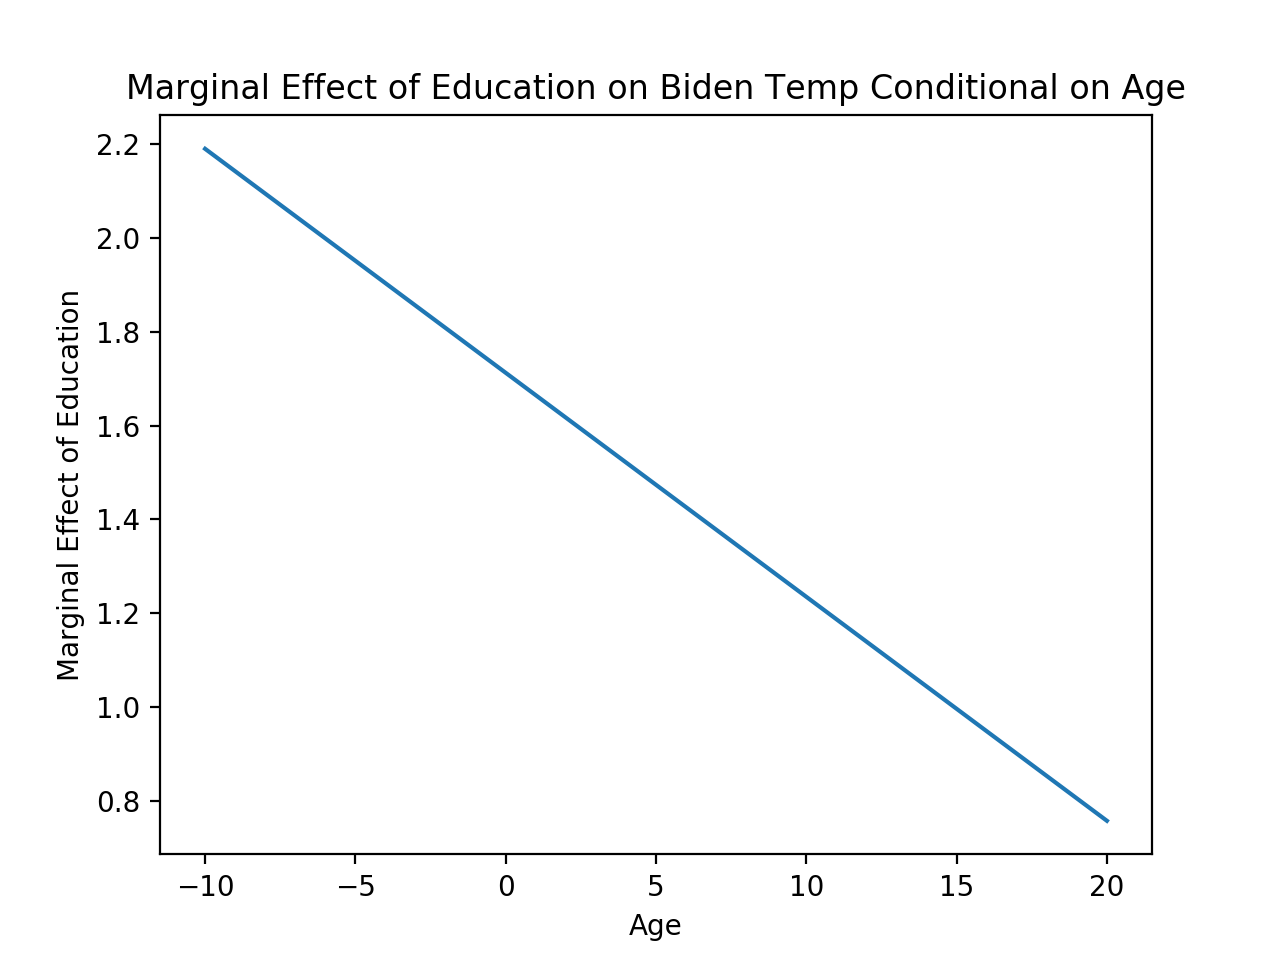

In [104]:
x = np.linspace(-10, 20, 100)    
fig, ax = plt.subplots()
ax.plot(x, (1.7123-0.0477*x))
ax.set_ylabel("Marginal Effect of Education")
ax.set_xlabel("Age")
ax.set_title("Marginal Effect of Education on Biden Temp Conditional on Age")
plt.show()

## Part 3
### (a)

In [113]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import timeit

autos = pd.read_csv("Auto.csv", na_values = "?")
autos.dropna(inplace=True)
autos.head(40)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino
5,15.0,8,429.0,198.0,4341,10.0,70,1,ford galaxie 500
6,14.0,8,454.0,220.0,4354,9.0,70,1,chevrolet impala
7,14.0,8,440.0,215.0,4312,8.5,70,1,plymouth fury iii
8,14.0,8,455.0,225.0,4425,10.0,70,1,pontiac catalina
9,15.0,8,390.0,190.0,3850,8.5,70,1,amc ambassador dpl


In [114]:
# Check to make sure there are no null values.
autos.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
year            0
origin          0
name            0
dtype: int64

In [123]:
autos['mpg_cat'] = pd.qcut(autos.mpg, 2, labels=False)
autos.head(20)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,constant,mpg_cat
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,1,0
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,1,0
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,1,0
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst,1,0
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino,1,0
5,15.0,8,429.0,198.0,4341,10.0,70,1,ford galaxie 500,1,0
6,14.0,8,454.0,220.0,4354,9.0,70,1,chevrolet impala,1,0
7,14.0,8,440.0,215.0,4312,8.5,70,1,plymouth fury iii,1,0
8,14.0,8,455.0,225.0,4425,10.0,70,1,pontiac catalina,1,0
9,15.0,8,390.0,190.0,3850,8.5,70,1,amc ambassador dpl,1,0


In [141]:
autos["constant"] = 1
y = autos.iloc[:,10]
Xplusconst = autos[['constant','cylinders','displacement','horsepower','weight','acceleration','year','origin']]

In [170]:
MSE_vec = np.zeros(100)
y_pred_vec = np.array([])
y_test_vec = np.array([])

start_time = timeit.default_timer()
for i in range(1, 100):
    x_train, x_test, y_train, y_test = train_test_split(Xplusconst, y, test_size = 0.35, random_state=i)
    LogReg = LogisticRegression()
    LogReg.fit(x_train, y_train)
    y_pred = LogReg.predict(x_test)
    y_pred_vec = np.append(y_pred_vec, y_pred)
    y_test_vec = np.append(y_test_vec, y_test)
    MSE_vec[i] = ((y_test != y_pred).astype(int)).mean()
    print("Error rate of set", i, "is", MSE_vec[i])
time_elapsed = timeit.default_timer() - start_time
print("The average error rate for this computation is", MSE_vec.mean())
print('This computation took', time_elapsed, 'seconds.')

Error rate of set 1 is 0.0507246376812
Error rate of set 2 is 0.130434782609
Error rate of set 3 is 0.0942028985507
Error rate of set 4 is 0.0869565217391
Error rate of set 5 is 0.0942028985507
Error rate of set 6 is 0.0942028985507
Error rate of set 7 is 0.123188405797
Error rate of set 8 is 0.108695652174
Error rate of set 9 is 0.0942028985507
Error rate of set 10 is 0.115942028986
Error rate of set 11 is 0.101449275362
Error rate of set 12 is 0.0724637681159
Error rate of set 13 is 0.101449275362
Error rate of set 14 is 0.108695652174
Error rate of set 15 is 0.0942028985507
Error rate of set 16 is 0.101449275362
Error rate of set 17 is 0.101449275362
Error rate of set 18 is 0.0869565217391
Error rate of set 19 is 0.108695652174
Error rate of set 20 is 0.0797101449275
Error rate of set 21 is 0.108695652174
Error rate of set 22 is 0.0724637681159
Error rate of set 23 is 0.0942028985507
Error rate of set 24 is 0.152173913043
Error rate of set 25 is 0.144927536232
Error rate of set 26 i

### (b)

In [171]:
from dask.distributed import Client
from dask import compute, delayed
import dask.multiprocessing

In [173]:
start_time2 = timeit.default_timer()
def logit(bootstrap_num, random_seed, x_vals, y_vals):
    x_train, x_test, y_train, y_test = train_test_split(Xplusconst, y, test_size = 0.35, random_state=random_seed)
    LogReg = LogisticRegression()
    LogReg.fit(x_train, y_train)
    y_pred = LogReg.predict(x_test)
    error = ((y_test != y_pred).astype(int)).mean()
    print("Error rate of set", bootstrap_num, "is", error)
    return error

lazy_values = []
for i in range(1,100):
    lazy_values.append(delayed(logit)(i, i, Xplusconst, y))

MSE_vec2 = compute(*lazy_values, get=dask.multiprocessing.get, num_workers=3)
time_elapsed2 = timeit.default_timer() - start_time2
print("The average error rate for this computation is", np.asarray(MSE_vec2).mean())
print('This computation took', time_elapsed2, 'seconds.')

Error rate of set 79 is 0.11594202898550725
Error rate of set 47 is 0.15217391304347827
Error rate of set 29 is 0.10869565217391304
Error rate of set 6 is 0.09420289855072464
Error rate of set 55 is 0.14492753623188406
Error rate of set 38 is 0.10144927536231885
Error rate of set 23 is 0.09420289855072464
Error rate of set 51 is 0.12318840579710146
Error rate of set 71 is 0.08695652173913043
Error rate of set 61 is 0.06521739130434782
Error rate of set 48 is 0.08695652173913043
Error rate of set 75 is 0.12318840579710146
Error rate of set 73 is 0.12318840579710146
Error rate of set 87 is 0.10869565217391304
Error rate of set 76 is 0.10869565217391304
Error rate of set 37 is 0.07971014492753623
Error rate of set 92 is 0.10869565217391304
Error rate of set 3 is 0.10144927536231885
Error rate of set 67 is 0.08695652173913043
Error rate of set 44 is 0.07971014492753623
Error rate of set 95 is 0.11594202898550725
Error rate of set 31 is 0.07246376811594203
Error rate of set 62 is 0.11594202

The dask computation got the same error rate as the normal computation (0.1), but it took more time than the previous computation. The same holds true if I do 1,000 iterations. I'm not sure why this is, but I'm guessing it is because DASK takes some upfront cost to set up, and thus it takes longer to execute a small job like this.